#### 0. Transformer 개요

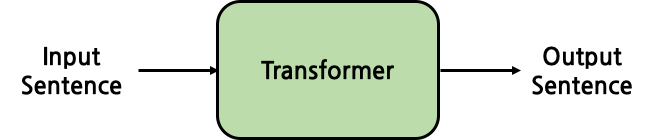

Trasformer는 크게 Encoder와 Decoder로 나뉜다.
- Encoder는 sentence를 input으로 받아 하나의 context를 생성해는 함수이다
- Decoder는 Encoder와 방향이 반대이다. context를 input으로 받아 sentence를 output으로 생성해낸다
- Encoder는 context를 생성해내고, Decoder는 context를 사용한다.

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder


    def encode(self, src, src_mask):
        out = self.encoder(src, src_mask)
        return out


    def decode(self, z, c):
        out = self.decode(z, c)
        return out


    def forward(self, src, tgt, src_mask):
        encoder_out = self.encode(src, src_mask)
        y = self.decode(tgt, encoder_out)
        return y

#### 1. Encoder 개요
- Encoder는 6개의 Block으로 이루어져 있다.
- 첫번째 Encoder Block의 input은 전체 Encoder의 input으로 들어오는 문장 embdding이 된다
- 첫번째 block Output은 두번째 block input으로 사용된다.

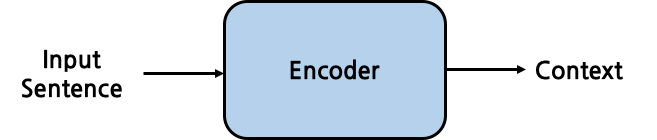

(상세)

- Encoder Block의 input과 output의 shape는 필연적으로 반드시 동일해야만 한다.
- 즉, Encoder Block은 shape에 대해 멱등(Idempotent) 하다.
- 6개의 Block이 서로의 출력을 입력으로 받기 때문에, 당연히 Encoder Block 뿐만 아니라 Encoder 전체도 shape에 대해 멱등(Idempotent)하다.

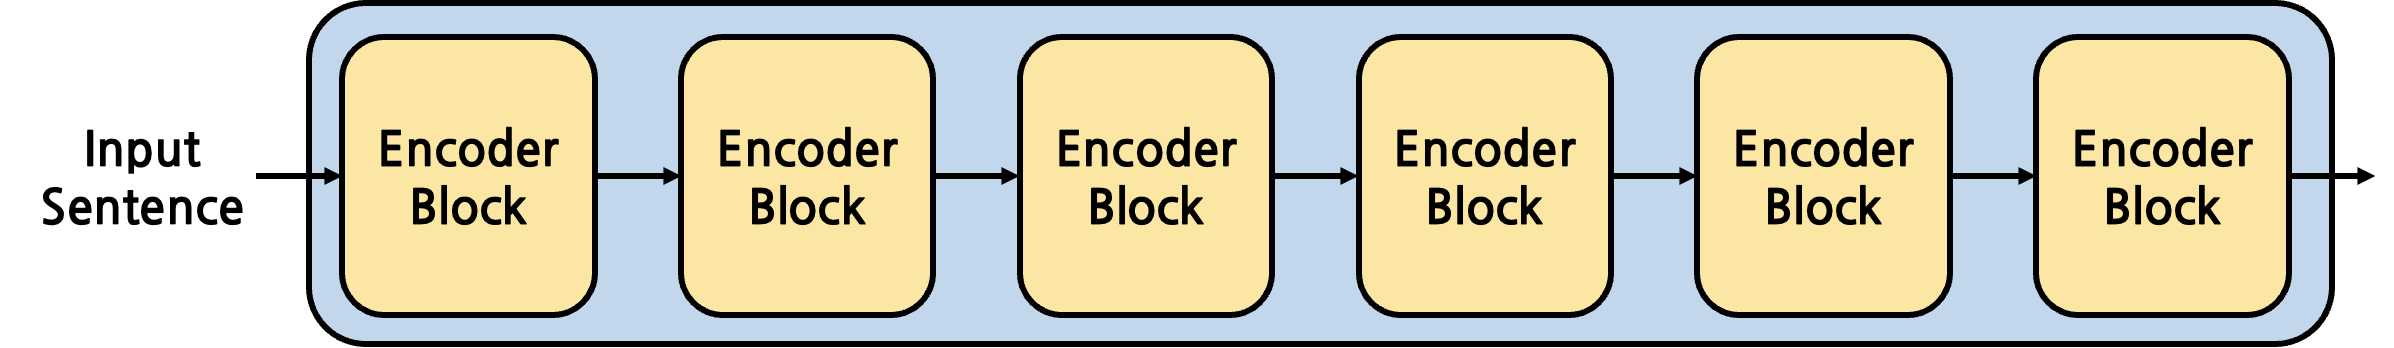

In [ ]:
class Encoder(nn.Module):

    def __init__(self, encoder_layer, n_layer):  # n_layer: Encoder Layer의 개수
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_layer))

             
    def forward(self, src, src_mask):
        out = src
        for layer in self.layers:
            out = layer(out, src_mask)
        return out

#### 1.1. Encoder Block 상세
- ncoder Block은 크게 Multi-Head Attention Layer, Position-wise Feed-Forward Layer로 구성된다.
- Multi-Head Attention은 Scaled Dot-Product-Attention을 병렬적으로 여러개 수행하는 layer이다.
- Attention이라는 것은 넓은 범위의 전체 data에서 특정한 부분에 집중한다는 의미이다.
- Scaled Dot-Product Attention 자체를 줄여서 Attention으로 부르기도 한다.

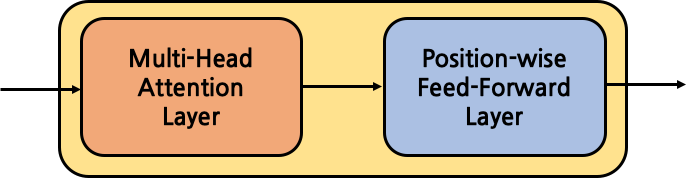

※ Self-Attention: 같은 문장 내의 두 token 사이의 Attention을 계산하는 것  
※ Cross-Attention: 서로 다른 두 문장에 각각 존재하는 두 token 사이의 Attention을 계산하는 것

**RNN vs Self-Attention**   
- RNN은 i 시점의 hidden state hi를 구하기 위해 $h_{i-1}$이 필요했다. 결국, 앞에서 부터 순차 계산을 해나가서 $h_i$, $h_{i+1}$을 구하기 때문에 병렬처리가 불가능 했다.
- 하지만 Self-Attention은 모든 token 쌍 사이의 attention을 한 번의 행렬 곱으로 구해내기 때문에 손쉽게 병렬 처리가 가능하다.
- Recurrent Network는 시간이 진행될수록 오래된 시점의 token에 대한 정보가 점차 희미해져간다. 왜냐하면, {hm, h_{m+1}, ... h_n} 으로 특정 구간 token들의 연관성을 살피기 때문이다.
- Self-Attention은 문장에 token이 n개 있다고 가정할 경우, n×n 번 연산을 수행해 모든 token들 사이의 관계를 직접 구해낸다. 중간의 다른 token들을 거치지 않고 바로 direct한 관계를 구하는 것이기 때문에 Recurrent Network에 비해 더 명확하게 관계를 잡아낼 수 있다.    


**Query, Key, Value**  
- 아래 문장을 예에서 it이 어느 것을 지칭하는지 알아내는 상황이라고 가정하자.  
"The animal didn’t cross the street, because it was too tired."
  
- 이 경우에는 Query는 ‘it’으로 고정이다. **Key, Value는 서로 완전히 같은 token을 가리키는데**, 문장의 시작부터 끝까지 모든 token들 중 하나가 된다.

- Key와 Value는 문장의 처음부터 끝까지 탐색한다고 이해하면 된다. Query는 고정되어 하나의 token을 가리키고, Query와 가장 부합하는(Attention이 가장 높은) token을 찾기 위해서 Key, Value를 문장의 처음부터 끝까지 탐색한다.
  
- Query, Key, Value는 input으로 들어오는 동일한 token embedding vector를 FC에 넣어 벡터를 생성하여 구하며 shape는 서로 같다. **하지만, Query, Key, Value를 생성하는 FC는 서로 다르다. 값도 서로 다르다** 
- 정리하면, 각각 별개의 FC layer로 구해진 Query, Key, Value가 구체적인 값은 다를지언정 같은 shape($d_k$)를 갖는 vector가 된다는 것을 알 수 있다.
  
- 여기서, Key와 Value가 완전히 같은 token을 가리킨다면 왜 두 개가 따로 존재하는지 의문이 들 수 있다. 결론부터 말하자면 Key와 Value의 실제 값은 다르지만 의미적으로는 여전히 같은 token을 의미한다. Key와 Value는 이후 Attention 계산 과정에서 별개로 사용하게 된다


**Scaled Dot-Product Attention**
- Query(Q), Key(K), Value(V)를 활용해 Query's Attention을 계산해 본다.
- Q는 현재 시점의 token을, K와 V 는 Attention을 구하고자 하는 대상 token을 의미한다.
- 미리 말하자면, 구해진 Query's Attention도 Q, K, V와 같은 shape($d_k$)를 가지는 벡터이다. 

$$ \text{Query's Attention}\left( Q, K, V \right) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V $$

- 위의 예시에서 'it'을 Q로 두고, K, V를 'animal'로 두고 Attention을 구한다고 가정해 보자
- $d_k$(Q, K, V가 FC를 통과해 구해진 벡터의 Shape)가 3이라고 하면 아래와 같은 모양이 된다.
- Q와 K는 같은 Shape이며 이 둘을 곱하기 위해 K를 Transpose 한 후에 $QK^T$를 구한다. 이때 값이 너무 커지지 않도록 $\sqrt{d_k}$로 나눠준다. 즉 Scaling 해준다.
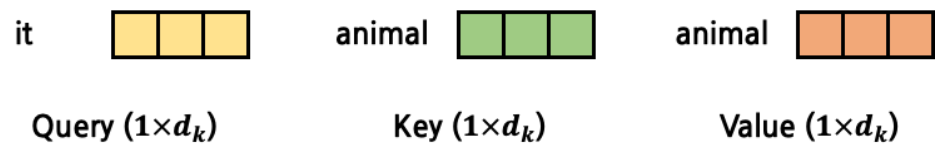
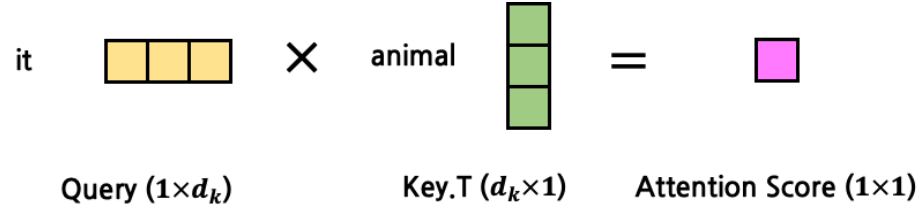

==> 즉, 둘 사이의 연관성을 점수로 나타내려면 무식하게 곱해서 점수로 나타낸다.

- it과 문장 토큰을 이렇게 1:1로 구하는 것 보다 1:N으로 구하는 것이 효율적일 것이다.
- Q vector 1개에 대해서 Attention을 계산한다고 했을 때, K와 V는 각각 문장 토큰 갯수 길이 만큼의 n길이의 vector가 된다.
- 이때, Q, K, V 벡터 차원은 모두 $d_k$로 동일하다.
- 정리하면, 아래와 같이 시각화 할 수 있다.
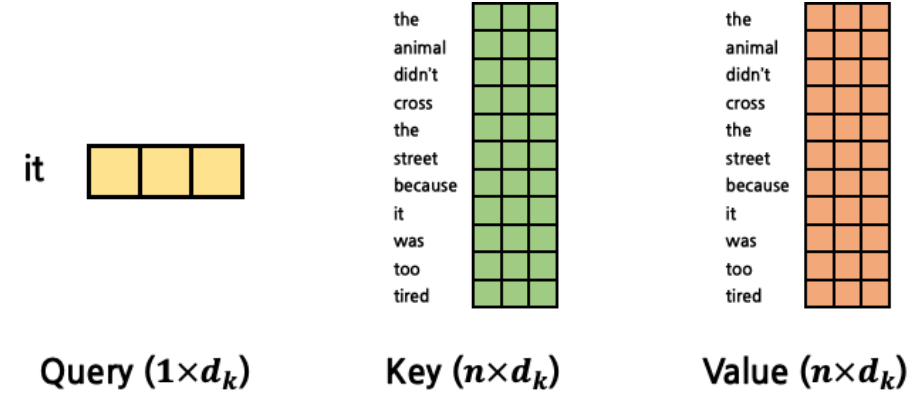
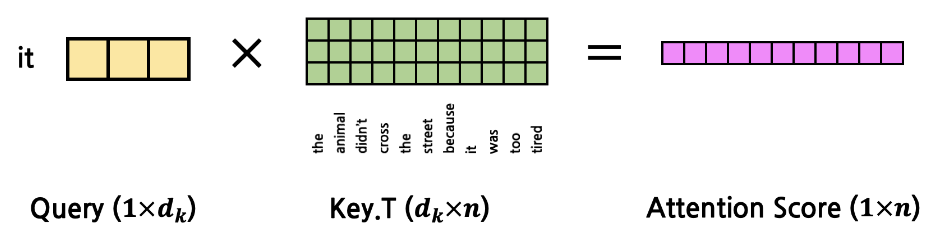

- 그 결과 Attention Score는 1×n의 matrix가 되는데, 이는 Q의 token과 문장 내 모든 token들 사이의 Attention Score를 각각 계산한 뒤 concatenate한 것과 동일하다. 이를 행렬곱 1회로 수행한 것이다.
- 이렇게 구한 Attention Score는 softmax를 사용해 확률값으로 변환하게 된다. 그 결과 각 Attention Probability는 모두 더하면 1인 확률값이 된다. 확률 값은 Q token과 각각의 token이 얼마나 연관성을 갖는지에 대한 비율이 된다.
- 위에서 구한 Attention Probability를 최종적으로 V와 곱하게 되는데, 이는 Q 대비 각 토큰의 확률 만큼만 반영하겠다는 의미이다.
<span style="color:greenyellow">   
==> Key와 Value는 동일한 token 이지만 Key는 Query와의 연관성 즉, 확률 구하는데 사용되며 Value는 구해진 확률 값이 곱해지는 주체이다.
</span>

- Query's Attention을 아래와 같이 정리할 수 있다.  
- 앞에서 언급했듯, Query's Attention도 Q, K, V와 같은 shape($d_k$)를 가지는 벡터 1개 이다.  
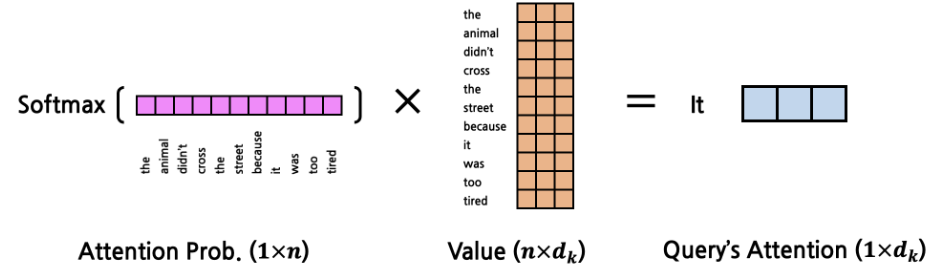

- 지금까지의 Attention 연산은 ‘it’이라는 한 token에 대한 Attention을 구한 것이다. 그러나 우리는 문장 내에서 ‘it’에 대한 Attention만 구하고자 하는 것이 아니다. 모든 token에 대한 Attention을 구해내야만 한다. (왜?)
  
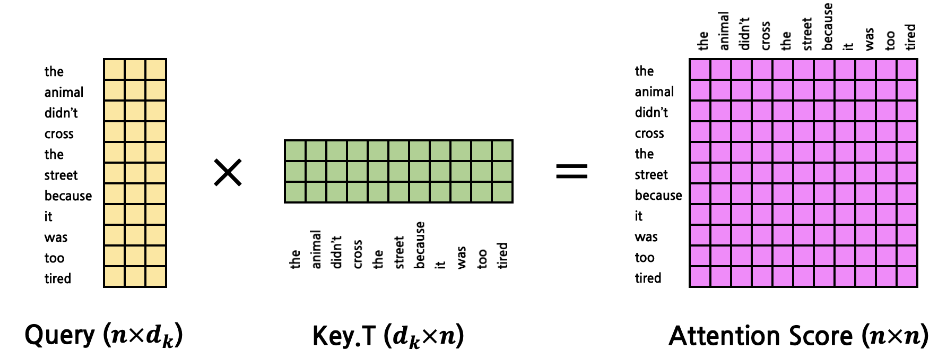
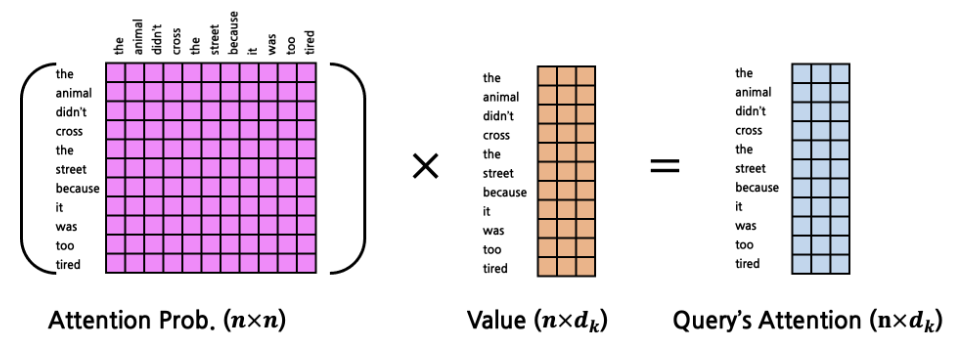


- 최종적으로 문장 전체를 Query 벡터로 나타낼 때, Self-Attention을 거쳐 계산한 Query's Attention은 아래와 같다.
- Self-Attention 연산 역시 shape에 멱등(Idempotent)하다  
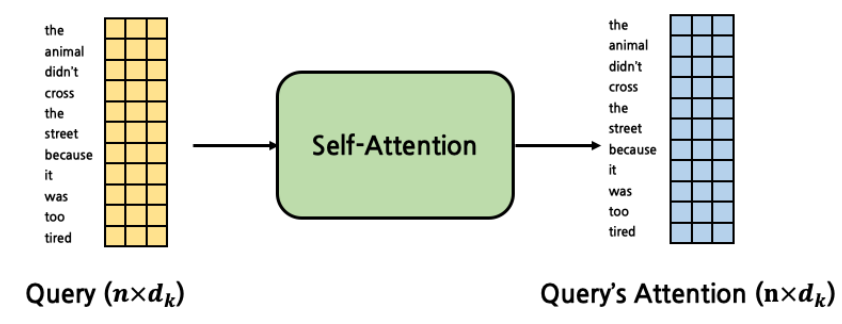

<span style="color:greenyellow">
==> 쉽게 표현하면, token이 서로가 서로에 대한 연관성을 확률 값으로 표현한다
</span>

- 위에서 본 Q, K, V 토큰 임베딩 벡터(각각 $nxd_k$ 차원)을 구하는 FC는 각기 다르다고 하였다.
- FC layer의 input은 word embedding vector들이고, output은 각각 Q, K, V이다. 
- 입력 shape는 모두 $n \times d_{embed}$이며, 출력 shape는 모두 $n x d_k$ 이다.
- 각각의 FC layer는 서로 다른 weight matrix ($d_{embed} \times d_k$)를 갖고 있기 때문에 output의 shape는 모두 동일할지라도, Q, K, V 의 실제 값들은 모두 다르다.
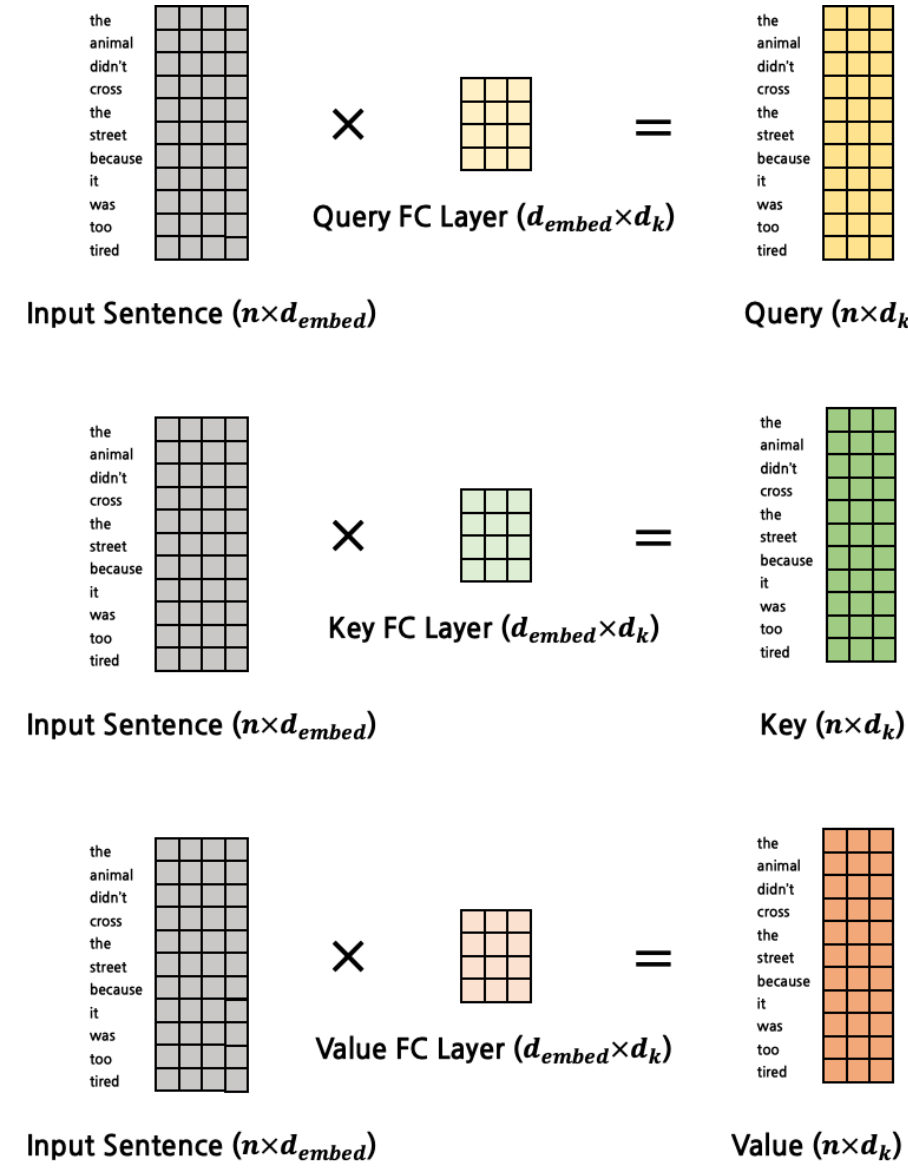

**Pad Masking**  
- "The animal didn’t cross the street, because it was too tired."  
- 문장을 word 단위로 tokenize(단순히 python의 split()을 사용)한다면 token의 개수는 총 11개이다.
- 실제 model 학습 과정에서는 한 문장 씩이 아닌 mini-batch씩 여러 문장이 와야 하는데 각 문장 마다의 length가 다를 경우 batch를 만들어낼 수 없다. 
- 이러한 문제를 해결하기 위해 seq_len(해당 mini-batch 내 token 개수의 최대 값)을 지정하게 되는데, 만약 seq_len
이 20이라고 한다면 위 문장에서는 9개의 빈 token이 있게 된다.
- 그런데, 이렇게 생겨난 비어있는 pad token에는 attention이 부여되어서는 안된다(Token이 없는 곳은 연관성을 파악할 필요가 없다)
- 따라서, 이러한 pad token들에 대해 attention이 부여되지 않도록 처리하는 것이 pad masking이다.
- masking은 (seq_len × seq_len) shape의 mask matrix를 곱하는 방식으로 이뤄지는데 mask matrix에서 pad token에 해당하는 row, column의 모든 값은 0이고, 그외는 모두 1이다.
- 이러한 연산은 scaling과 softmax 사이에 수행하게 되는데, 사실은 scaling 이전, 이후 언제 적용하든 차이는 없다.
- scaling은 단순히 모든 값을 dk로 일괄 나누는 작업이기 때문이다. 대신 반드시 Q와 K 의 행렬곱 이후, softmax 이전에 적용되어야 한다. 그래야만, softmax 계산 이후 확률 합이 1이 되기 때문이다.
- 아래와 같이 이해하면 편할 듯 하다  
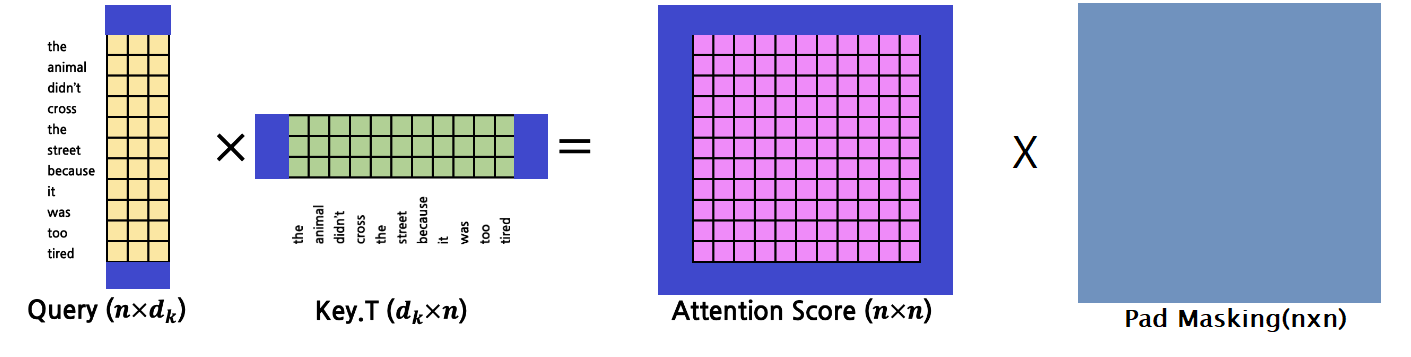

**Self-Attention Code in Pytorch**
- 모델에 들어오는 input은 한개의 문장이 아닌 padding이 적용된 mini-batch 이므로, Q, K, V 의 shape는 $ n_{batch} \times seqlen \times d_{embed} $ 이게 되며 각각 FC를 거쳐 $ n_{batch} \times seqlen \times d_k $ 가 된다.

In [ ]:
def calculate_attention(query, key, value, mask):
    # query, key, value: (n_batch, seq_len, d_k)
    # mask: (n_batch, seq_len, seq_len)
    d_k = key.shape[-1]
    attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, seq_len, seq_len)
    attention_score /= math.sqrt(d_k)

    if mask is not None:
        attention_score = attention_score.masked_fill(mask==0, -1e9)
    attention_prob  = F.softmax(attention_score, dim=-1) # (n_batch, seq_len, seq_len)
    out = torch.matmul(attention_prob, value) # (n_batch, seq_len, d_k)
    return out

#### 1.1.1 Multi-Head Attention Layer
- Attention 계산을 논문에서는 Scaled Dot-Product Attention이라고 명명한다.
- Transformer는 Scaled Dot Attention을 한 Encoder Layer마다 1회씩 수행하는 것이 아니라 병렬적으로 h 회 각각 수행한 뒤, 그 결과를 종합해 사용한다.
- 이것이 Multi-Head Attention이다.
- 논문에서는 h=8을 채택했다. 
- Scaled Dot-Product Attention에서는 Q, K, V를 위해 FC layer가 총 3개 필요했었는데, 이를 h
회 수행한다고 했으므로 3∗h개의 FC layer가 필요하게 된다.
  
- 각 연산의 최종 output은 ($seq\_len \times d_k$) 의 shape인데, h개 행렬을 모두 concatenate해서 $seq\_len \times (d_k * h)$ 모양을 갖는 행렬을 만들어 낸다. 
- 이때 d_k * h 값을 d_model로 명명한다. 중요한 개념이라고 한다.
- 대개 d_model은 Encoder의 input으로 들어오는 shape인 d_embed 와 동일한 값을 사용한다.

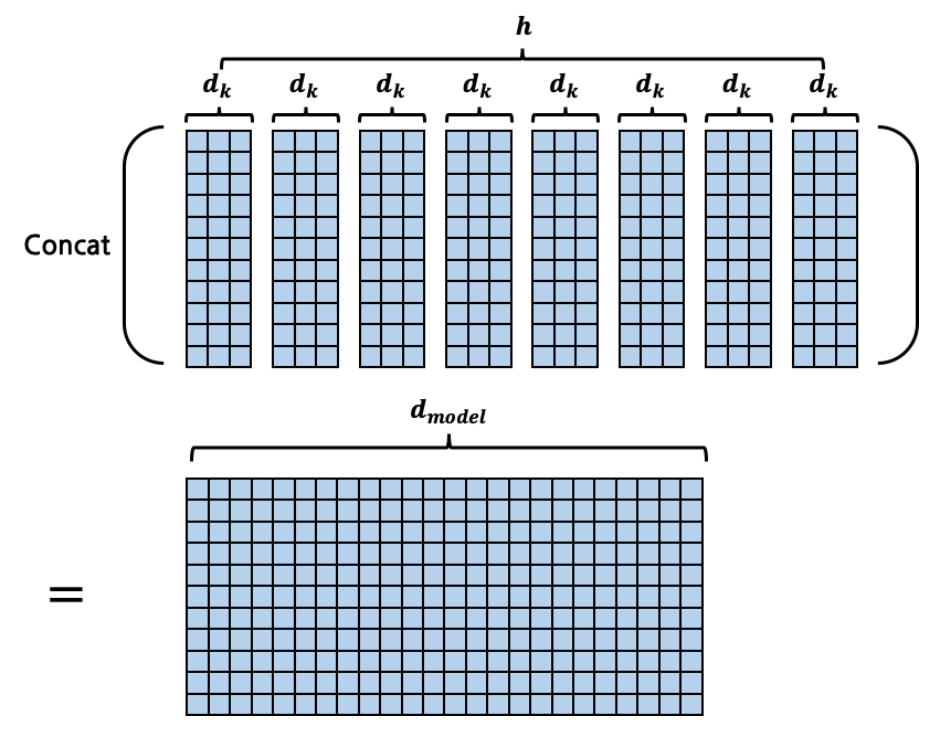

- 실제로는 위의 그림 처럼 Q, K, V로 각각의 FC로 곱해서 seq_len x dk 사이즈의 행렬을 h번 구한 뒤 Concatenate 하는 비효율 적인 방법을 사용하진 않는다.
- Q, K, V 자체를 seq_len × d_k가 아닌, seq_len × d_model 로 생성해내서, 한번의 Self-Attention 계산으로 seq_len x d_model의 출력을 만들어 낸다.

<span style="color:greenyellow">
==> d_embed × dk 의 weight matrix를 갖는 FC layer를 3∗h 개 운용할 필요 없이 d_embed × d_model
의 weight matrix를 갖는 FC layer를 3개만 운용하면 된다.
</span>

- 여기서 우리가 주목해야 하는 지점은 다양한 Attention을 반영한다는 Multi-Head Attention의 심오한 개념은 실제 구현상으로는 단지 dk의 크기를 dmodel 로 확장시키는 단순한 변경으로 끝난다는 점이다.

- 최종적으로 생성해된 matrix (n × d_model)를 FC layer에 넣어 multi-head attention의 input과 같은 shape(n × d_embed)의 matrix로 변환하는 과정이 필요하다. (n == seq_len)
- 따라서, 마지막 FC의 input demension은 d_model, output demention은 d_embed가 된다  
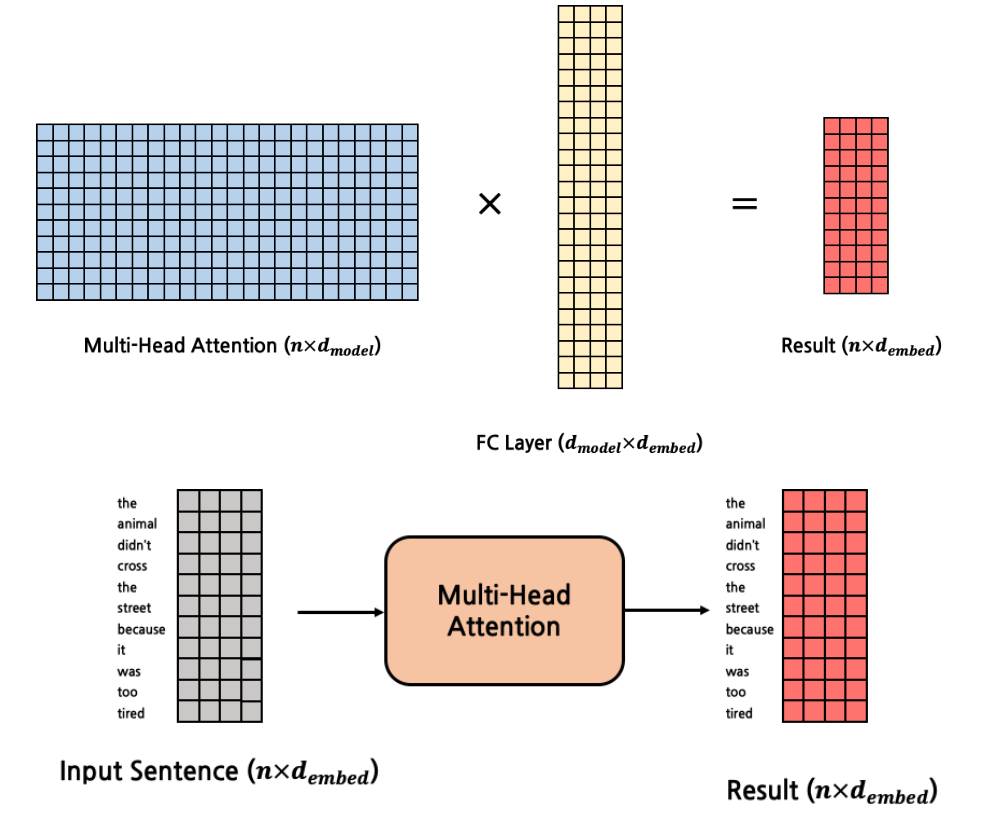

(이하 아래 코드 설명)
- Q, K, V에는 서로 다른 FC가 곱해지므로 deepcopy를 반드시 수행한다.
- query, key, value는 FC로 부터 계산된 값이 아닌 그 전 값인 input sentence embedding (n_batch × seq_len × d_embed) 이다.

- mask는 기본적으로 한 문장에 대해 (seq_len × seq_len)의 shape를 갖는데, mini-batch이므로 (n_batch × seq_len × seq_len)의 shape를 갖는다.

In [ ]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, d_model, h, qkv_fc, out_fc):
        super(MultiHeadAttentionLayer, self).__init__()
        self.d_model = d_model
        self.h = h
        self.q_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), FC Layer
        self.k_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), FC Layer
        self.v_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), FC Layer
        self.out_fc = out_fc              # (d_model, d_embed)

    def calculate_attention(self, query, key, value, mask):
        # query, key, value: (n_batch, h, seq_len, d_k)
        # mask: (n_batch, 1, seq_len, seq_len) # 마스크는 Q, K, V에 동일하게 사용하나 보다
        d_k = key.shape[-1]
        attention_score = torch.matmul(query, key.transpose(-2, -1)) 
        # Q x K^T, (n_batch, h, seq_len, seq_len)
        attention_score = attention_score / math.sqrt(d_k)
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -1e9)
        attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, h, seq_len, seq_len)
        out = torch.matmul(attention_prob, value) # (n_batch, h, seq_len, d_k)
        return out   

    def forward(self, *args, query, key, value, mask=None):
        # query, key, value: (n_batch, seq_len, d_embed)
        # mask: (n_batch, seq_len, seq_len)
        # return value: (n_batch, h, seq_len, d_k)
        n_batch = query.size(0)

        def transform(x, fc):
            out = fc(x)                     # (n_batch, seq_len, d_model)
            out = out.view(n_batch, -1, self.h, self.d_model // self.h) 
            # (n_batch, seq_len, d_model) -> (n_batch, seq_len, h, d_k) ★★★
            out = out.tranpose(1, 2) # (n_batch, h, seq_len, d_k)

        # token embedding 생성!!!
        query = transform(query, self.q_fc) # (n_batch, h, seq_len, d_k)
        key = transform(key, self.k_fc)     # (n_batch, h, seq_len, d_k)
        value = transform(value, self.v_fc) # (n_batch, h, seq_len, d_k)

        out = self.calcutate_attention(query, key, value, mask) # (n_batch, h, seq_len, d_k)
        out = out.transpose(1, 2) # (n_batch, seq_len, h, d_k)
        out = out.contiguous().view(n_batch, -1, self.d_model) # (n_batch, seq_len, d_model)
        out = self.out_fc(out) # (n_batch, seq_len, d_embed)
        return out

- transform()은 Q, K, V를 구하는 함수이다. 따라서 input shape는 x:(n_batch × seq_len × d_embed
), fc: (d_embed_ x d_model)이고, output shape는 (n_batch × seq_len × d_model)이어야 한다. 
  
- 하지만 실제로는 단순히 FC Layer만 거쳐가는 것이 아닌 추가적인 변형이 일어난다. 우선 d_model 을 h
와 dk로 분리하고, 각각을 하나의 dimension으로 분리한다.

- 따라서 shape는 (n_batch × seq_len × h × dk)가 된다. 이를 다시 transform 하여 (n_batch × h x seq_len × dk)로 만든다.

- 위의 transform 연산에서 d_model을 분리하는 이유는 위애서 작성한 calculate_attention()이 input으로 받는 shape가 (n_batch x ... x seq_len x d_k) 이기 때문이다.

- Q, K, V의 마지막 dimension은 반드시 dk 여야만 한다.

- 또한, attention_score의 shape는 마지막 두 dimension이 반드시 (seq_len × seq_len
)이어야만 masking이 적용될 수 있다.

- calculate_attention()을 사용해 attention을 계산하고 나면 그 shape는 (n_batch × h × seq_len × dk)이다 (Value 연산 까지 곱하고 나면)

- Multi-Head Attention Layer 역시 shape에 대해 멱등(Idempotent)해야만 하기 때문에, output shape는 input과 같은 (n_batch × seq_len × d_embed)여야만 한다. 

- 이를 위해 h와 seq_len의 순서를 뒤바꾸고(.transpose(1, 2)) 다시 h와 dk를 dmodel로 결합한다.
- 이후 FC Layer를 거쳐 d_model을 d_embed로 변환하게 된다.

#### 1.2 Encoder Block 코드

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff

    def forward(self, src, src_mask):
        out = src
        out = self.self_attention(query=out, key=out, value=out, mask=src_mask)
        out = self.position_ff(out)
        return out

**Position-wise Feed Forward Layer**
- 단순하게 2개의 FC Layer를 갖는 Layer이다. 각 FC Layer는 (d_embed×d_ff
), (d_ff×d_embed)의 weight matrix를 갖는다. 즉, Feed Forward Layer 역시 shape에 대해 멱등(Idempotent)하다
- Feed Forward Layer는 Multi-Head Attention Layer의 output을 input으로 받아 연산을 수행하고, 다음 Encoder Block에게 output을 넘겨준다

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):

    def __init__(self, fc1, fc2):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.fc1 = fc1   # (d_embed, d_ff)
        self.relu = nn.ReLU()
        self.fc2 = fc2 # (d_ff, d_embed)


    def forward(self, x):
        out = x
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

**Residual Connection Layer**
- 실제로 Encoder Block은 Multi-Head Attention Layer와 Position-Wise FF Layer가 Residual Connection으로 연결되어 있다.   
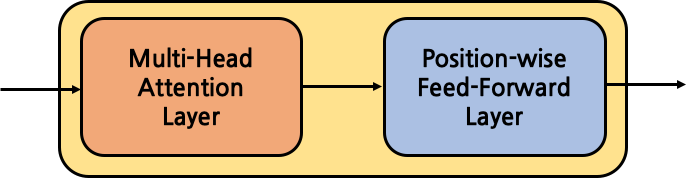

In [ ]:
class ResidualConnectionLayer(nn.Module):

    def __init__(self):
        super(ResidualConnectionLayer, self).__init__()

    def forward(self, x, sub_layer):
        out = x
        out = sub_layer(out)
        out = out + x
        return out

- Encoder Block의 code가 아래와 같이 변경되게 된다. residuals에 Residual Connection Layer를 2개 생성한다. forward()에서 residuals[0]은 multi_head_attention_layer를 감싸고, residuals[1]은 position_ff를 감싸게 된다.
- Encoder Block은 아래와 같이 수정된다.

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(2)]

    def forward(self, src, src_mask):
        out = src
        out = self.residuals[0](out, lambda out: self.self_attention(query=out, key=out, value=out, mask=src_mask))
        out = self.residuals[1](out, self.position_ff)
        return out

#### 2. Decoder
- Decoder는 context와 Some Sentence를 input으로 받아 Output Sentence를 출력한다.
- Encoder 내부에서 Multi-Head Attention Layer나 Position-wise Feed-Forward Layer 모두 shape에 멱등(Idempotent)했음을 주목하자.
- 때문에 이 두 Layer로 구성된 Encoder Block도 shape에 멱등(Idempotent)할 것이고,
- Encoder 전체도 shape에 멱등(Idempotent)할 것이다. 따라서 Encoder의 output인 context는 Encoder의 input인 sentence와 동일한 shape를 갖는다.

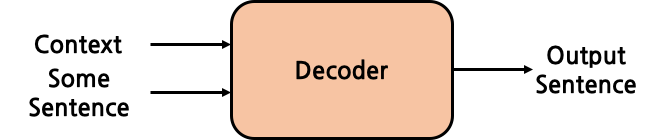

**Teacher Forcing**
- Teacher Forcing은 실제 labeled data(Ground Truth)를 RNN cell의 input으로 사용하는 것이다. 정확히는 Ground Truth의 [:-1]로 slicing을 한 것이다(마지막 token인 EOS token을 제외하는 것이다).  
- 이를 통해서 model이 잘못된 token을 생성해내더라도 이후 제대로 된 token을 생성해내도록 유도할 수 있다.

**Teacher Forcing in Transformer (Subsequent Masking)**
- Teacher Forcing 개념을 이해하고 나면 Transformer Decoder에 input으로 들어오는 sentence가 어떤 것인지 이해할 수 있다. ground truth[:-1]의 sentence일 것이다.
- 하지만 Transformer가 RNN에 비해 갖는 가장 큰 장점은 병렬 연산이 가능하다는 것이었다. 병렬 연산을 위해 ground truth의 embedding을 matrix로 만들어 input으로 그대로 사용하게 되면, Decoder에서 Self-Attention 연산을 수행하게 될 때 (현재) 출력해내야 하는 token의 정답까지 알고 있는 상황이 발생한다.
- 따라서 masking을 적용해야 한다. i 번째 token을 생성해낼 때, 1∼i−1 의 token은 보이지 않도록 처리를 해야 하는 것이다. 이러한 masking 기법을 subsequent masking이라고 한다. 

In [ ]:
def make_subsequent_mask(query, key):
    query_seq_len, key_seq_len = query.size(1), key.size(1)

    tril = np.tril(np.ones((query_seq_len, key_seq_len)), k=0).astype('uint8')
    mask = torch.tensor(tril. dtype=torch.bool, requires_grad=False, device=query.device)
    return mask

- make_subsequent_mask()는 np.tril()을 사용해 하 삼각 행렬을 생성한다. 아래는 query_seq_len과 key_seq_len이 모두 10일 때, np.tril()의 결과이다.

In [ ]:
[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

- Decoder의 mask는 subsequent masking이 적용되어야 한다. 그런데, 동시에 Encoder와 마찬가지로 pad masking역시 적용되어야 한다. 따라서, make_tgt_mask()는 다음과 같다.

In [ ]:
def make_tgt_mask(self, tgt):
    pad_mask = self.make_pad_mask(tgt, tgt) # 패딩을 하고
    seq_mask = self.make_subsequent_mask(tgt, tgt) # 마스킹 적용
    mask = pad_mask & seq_mask
    return mask

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder


    def encode(self, src, src_mask):
        out = self.encoder(src, src_mask)
        return out


    def decode(self, tgt, encoder_out, tgt_mask):
        out = self.decode(tgt, encoder_out, tgt_mask)
        return out

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        encoder_out = self.encode(src, src_mask)
        y = self.decode(tgt, encoder_out, tgt_mask)
        return y

#### 2.1 Decoder Block
- Decoder Block은 Encoder Block과 달리 Multi-head attention layer가 2개 들어 간다.
- 첫번째 layer는 Self-Multi-Head Attention Layer라고 부르는데, 이름 그대로 Decoder의 input으로 주어지는 sentence 내부에서의 Attention을 계산한다. 이 때, 일반적인 pad masking뿐만 아니라 subsequent masking이 적용되기 떄문에 Masked-Multi-Head Attention Layer라고 부르기도 한다. 
- 두번째 layer는 Encoder에서 넘어온 context를 Key, Value로 사용한다는 점에서 Cross-Multi-Head Attention Layer라고 부른다. 즉, Encoder의 context는 Decoder 내 각 Decoder Block의 Cross-Multi-Head Attention Layer에서 사용되게 된다. 
  
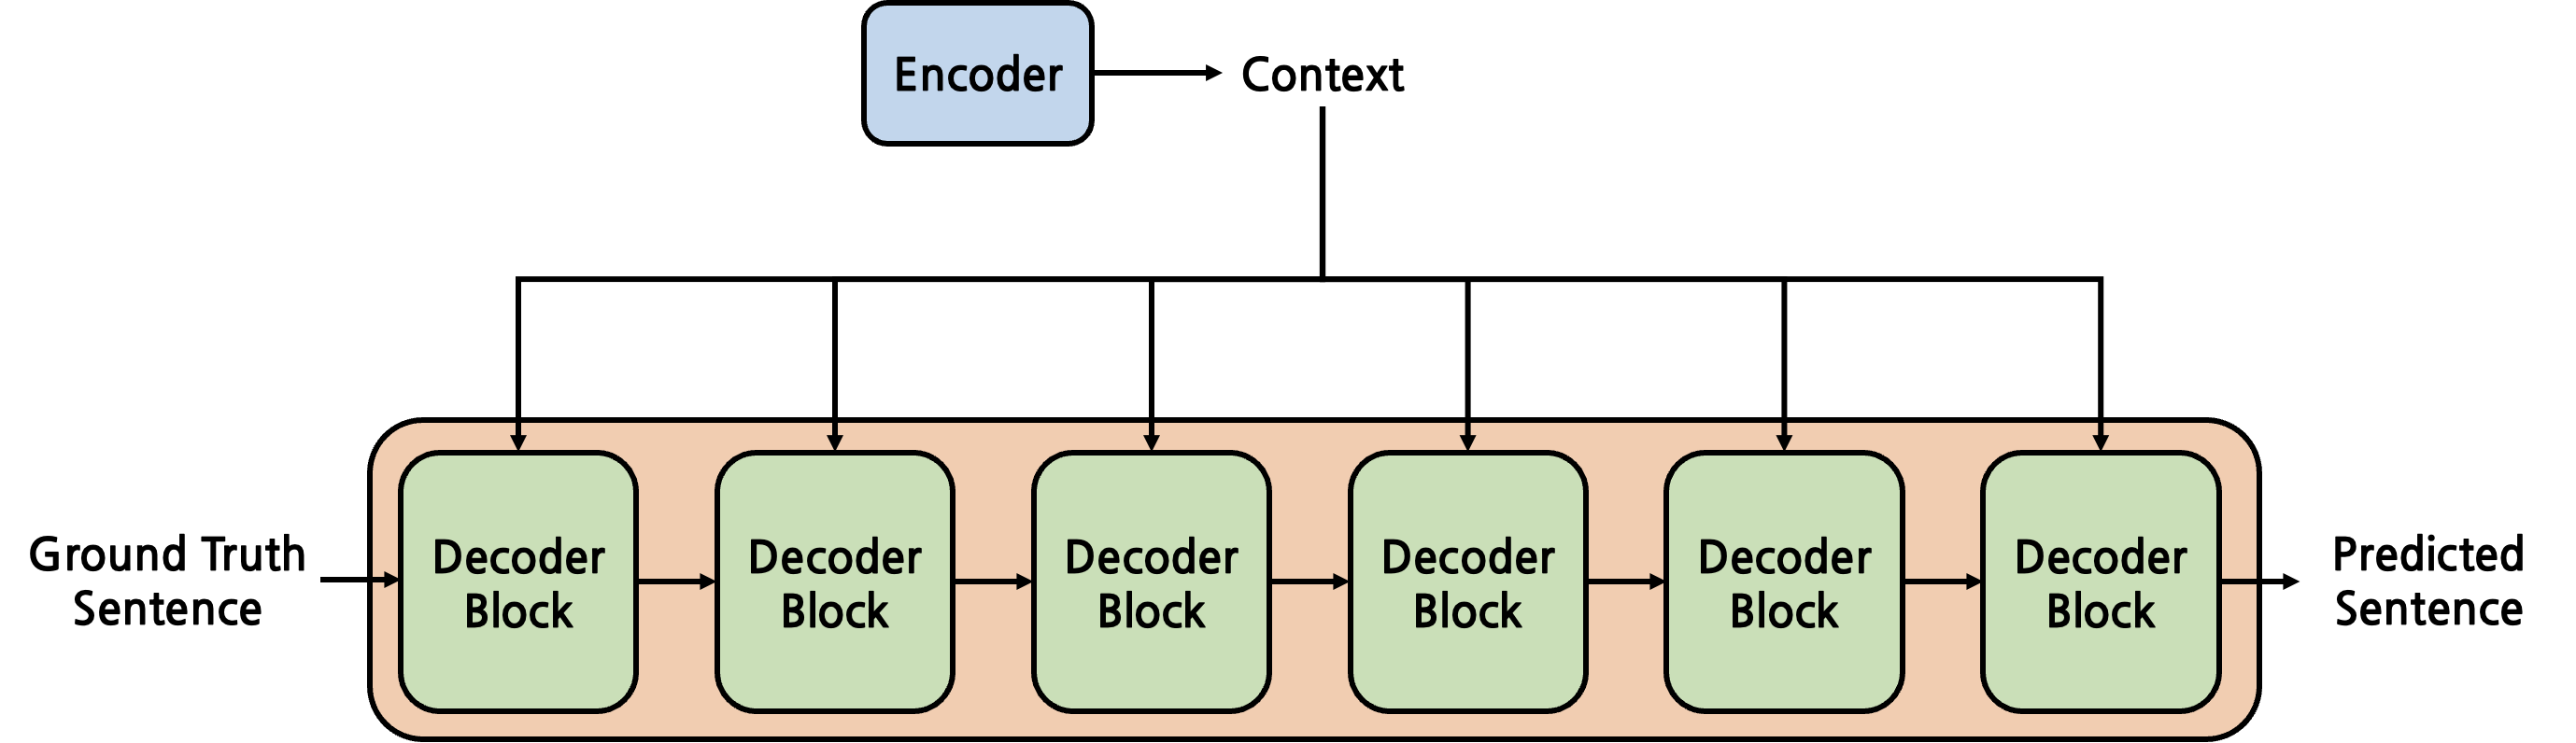
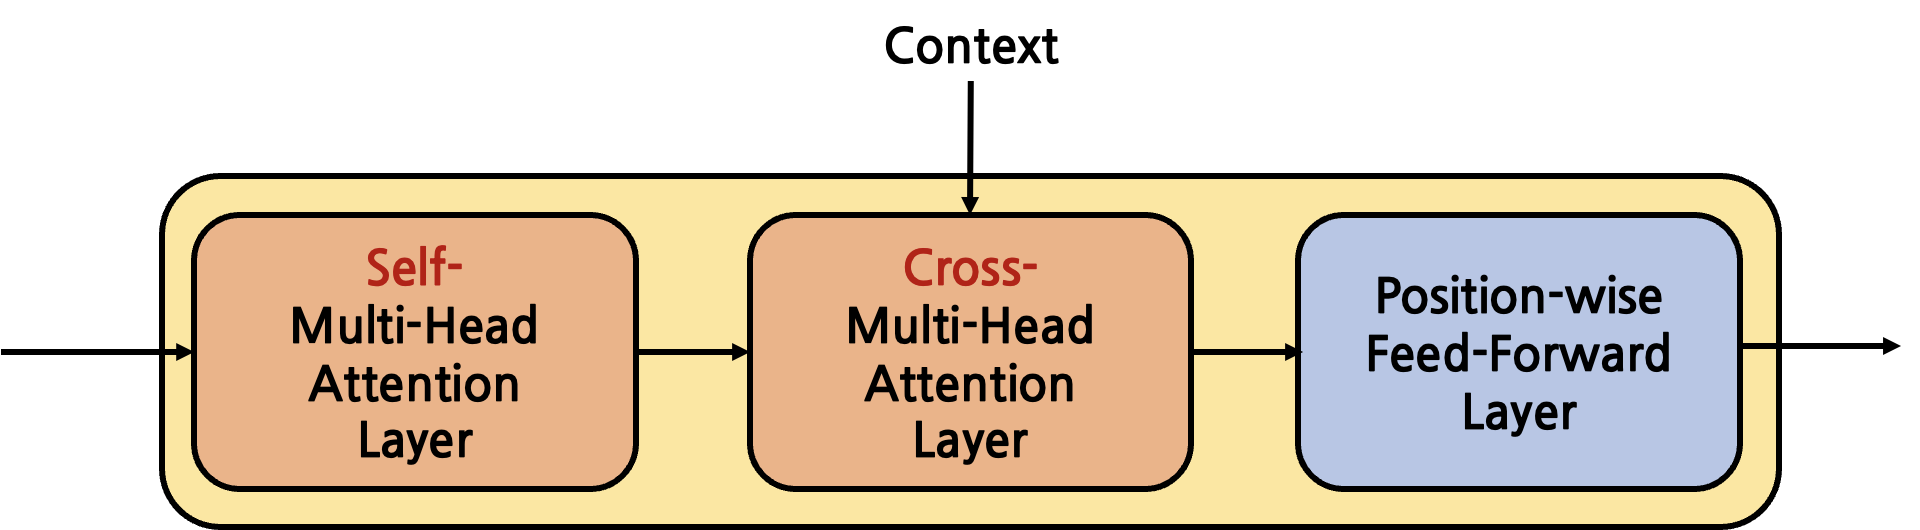
